In [1]:
#Python == 3.9.16
#Anndata==0.9.1
#scglue==0.3.2
#bedtools==2.29.2

In [2]:
pip install numpy==1.24.0

Note: you may need to restart the kernel to use updated packages.


In [68]:
import anndata as ad
import networkx as nx
import scanpy as sc
import scglue
import numpy as np
import pandas as pd
from matplotlib import rcParams

In [ ]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

## Read the data

In [5]:
multiom = ad.read_h5ad("GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")
multiom

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [6]:
multiom = multiom[multiom.obs['Site'].isin(['site1', 'site2'])].copy() #select site1 and site2 as a reference
multiom

AnnData object with n_obs × n_vars = 32469 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [7]:
atac_multiom = multiom[:, multiom.var['feature_types'] == 'ATAC'].copy()
rna_multiom = multiom[:, multiom.var['feature_types'] == 'GEX'].copy()
rna_multiom, atac_multiom

(AnnData object with n_obs × n_vars = 32469 × 13431
     obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
     var: 'feature_types', 'gene_id'
     uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
     obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 32469 × 116490
     obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist

In [8]:
assert np.sum(rna_multiom.obs_names != atac_multiom.obs_names) == 0 #we make sure that cells are the same in multiome data

In [9]:
cite = ad.read_h5ad("GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")
cite

/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [10]:
cite = cite[cite.obs['Site'].isin(['site1', 'site2'])].copy() #select site1 and site2 as a reference
cite

/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 41482 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [11]:
adt_cite = cite[:, cite.var['feature_types'] == 'ADT'].copy()
rna_cite = cite[:, cite.var['feature_types'] == 'GEX'].copy()
adt_cite, rna_cite

(AnnData object with n_obs × n_vars = 41482 × 134
     obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
     var: 'feature_types', 'gene_id'
     uns: 'dataset_id', 'genome', 'organism'
     obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 41482 × 13953
     obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot',

In [12]:
assert np.sum(rna_cite.obs_names != adt_cite.obs_names) == 0 #we make sure that cells are the same in cite data

In [13]:
#Because batch names are the same for different modalities and datasets, we will need to update a bunch of batch columns in .obs so we create a helper function for this.
def update_obs_column(
    adata, obs_column_name, suffix, how="right", new_obs_column_name=None
):
    if new_obs_column_name is None:
        new_obs_column_name = f"new_{obs_column_name}"
    # otherwise can't use + operator with categorical columns
    adata.obs[obs_column_name] = adata.obs[obs_column_name].astype("str").copy()
    # create new column in .obs
    if how == "right":
        adata.obs[new_obs_column_name] = f"_{suffix}"
        adata.obs[new_obs_column_name] = (
            adata.obs[obs_column_name] + adata.obs[new_obs_column_name]
        )
    else:
        adata.obs[new_obs_column_name] = f"{suffix}_"
        adata.obs[new_obs_column_name] = (
            adata.obs[new_obs_column_name] + adata.obs[obs_column_name]
        )
    return adata

In [14]:
rna_multiom = update_obs_column(rna_multiom, "batch", "_rna_multiome")
atac_multiom = update_obs_column(atac_multiom, "batch", "_atac_multiome")
rna_cite = update_obs_column(rna_cite, "batch", "_rna_cite")
adt_cite = update_obs_column(adt_cite,  "batch", "_adt_cite")

/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:537: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:537: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:537: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:537: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


## Preprocess RNA-seq

In [15]:
rna = rna_multiom.concatenate(rna_cite, batch_key='concat_key', index_unique=None)
rna

/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 73951 × 12059
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'new_batch', 'GEX_n_genes_by_counts', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'ADT_pseudotime_order', 'is_train', 'concat_key'
    var: 'feature_types', 'gene_id-0', 'gene_id-1'
    obsm: 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [16]:
rna.X = rna.layers["counts"].copy()

In [17]:
sc.pp.highly_variable_genes(rna, n_top_genes=4000, flavor="seurat_v3")

In [18]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

In [19]:
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)

/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-

/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


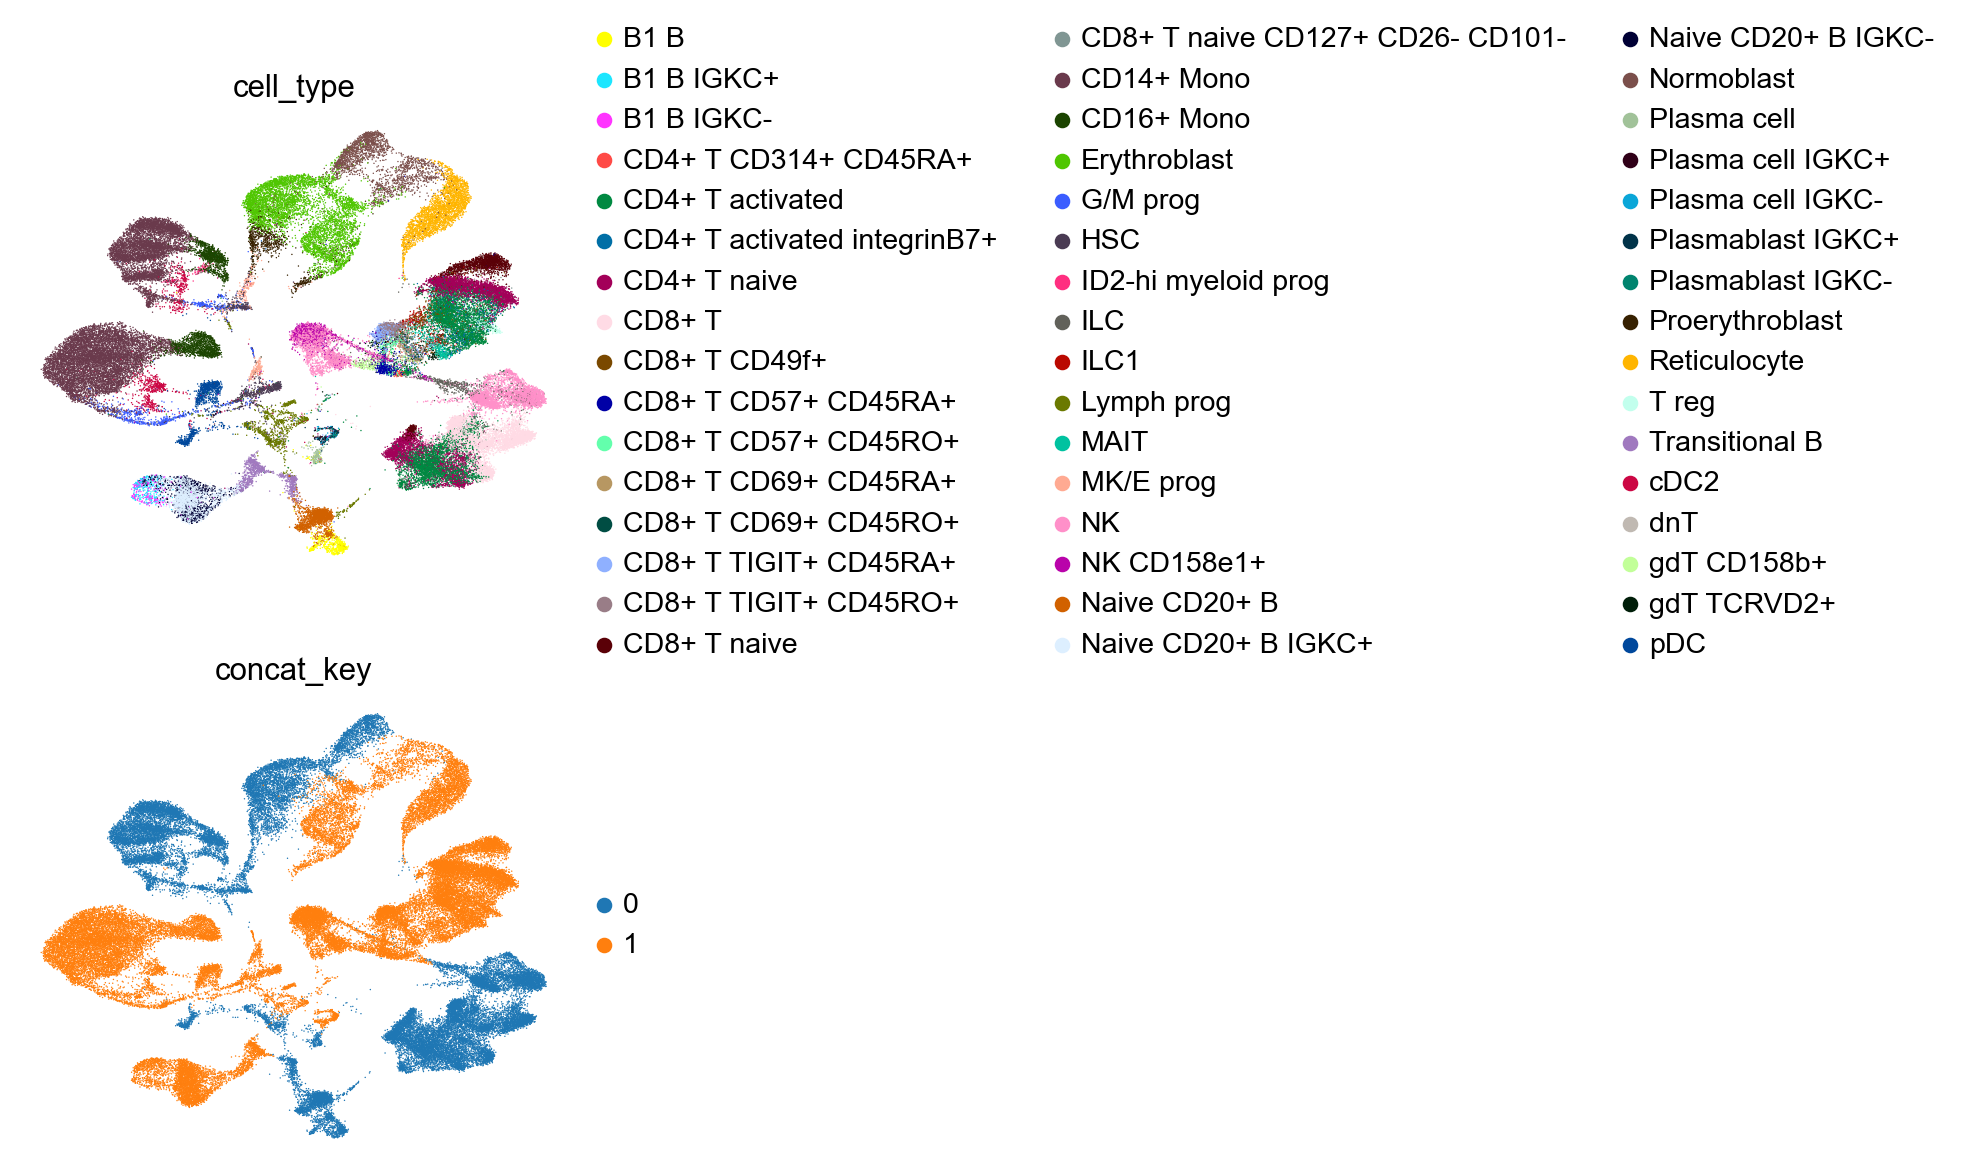

In [20]:
sc.pl.umap(rna, color=["cell_type", "concat_key"], ncols=1, frameon=False)

In [21]:
rna.X = rna.layers["counts"].copy()

## Preprocess ATAC

In [22]:
atac_multiom.X = atac_multiom.layers['counts'].copy()
atac_multiom.X 

<32469x116490 sparse matrix of type '<class 'numpy.float32'>'
	with 102580869 stored elements in Compressed Sparse Row format>

In [23]:
atac_multiom.layers['tf-idf'] = atac_multiom.X.copy()

In [24]:
sc.pp.normalize_total(atac_multiom, target_sum=1e4)
sc.pp.log1p(atac_multiom)

In [25]:
sc.pp.highly_variable_genes(atac_multiom, n_top_genes=20000, batch_key='batch') #subset to top 20000 peaks

In [26]:
scglue.data.lsi(atac_multiom, n_components=100, n_iter=15) #The LSI embedding will be used in stage 2 as the first encoder transformation to reduce model size.

In [27]:
sc.pp.neighbors(atac_multiom, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac_multiom)

/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


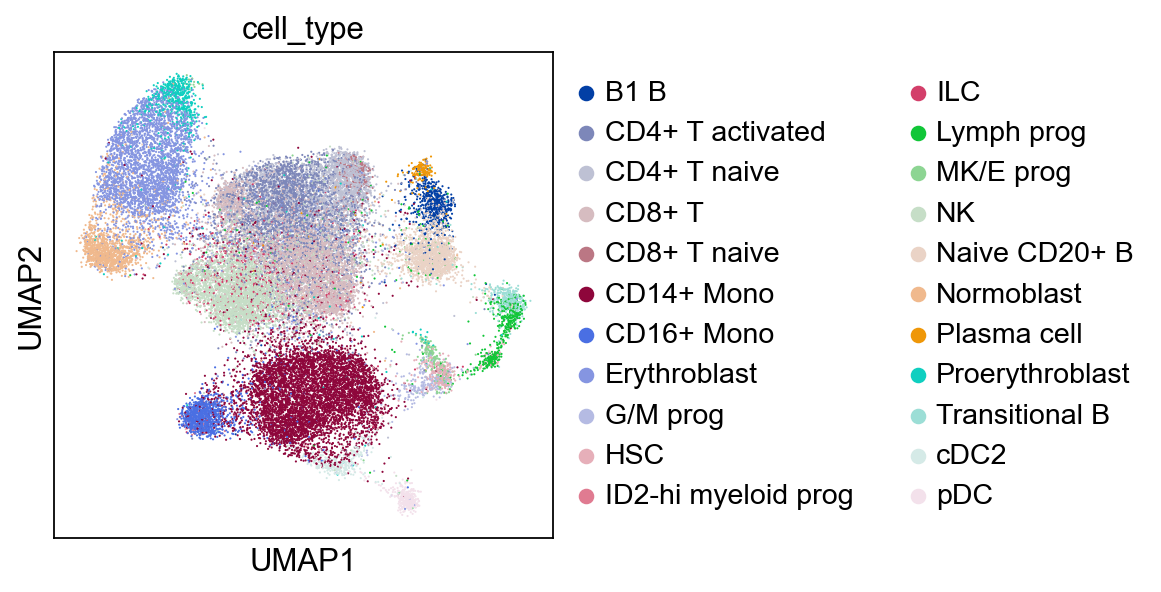

In [28]:
sc.pl.umap(atac_multiom, color="cell_type")

## Preprocess ADT

In [29]:
np.max(adt_cite.X)

7.7640185

In [30]:
sc.tl.pca(adt_cite, n_comps=100, svd_solver="auto")

In [31]:
sc.pp.neighbors(adt_cite, metric="cosine")
sc.tl.umap(adt_cite)

/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


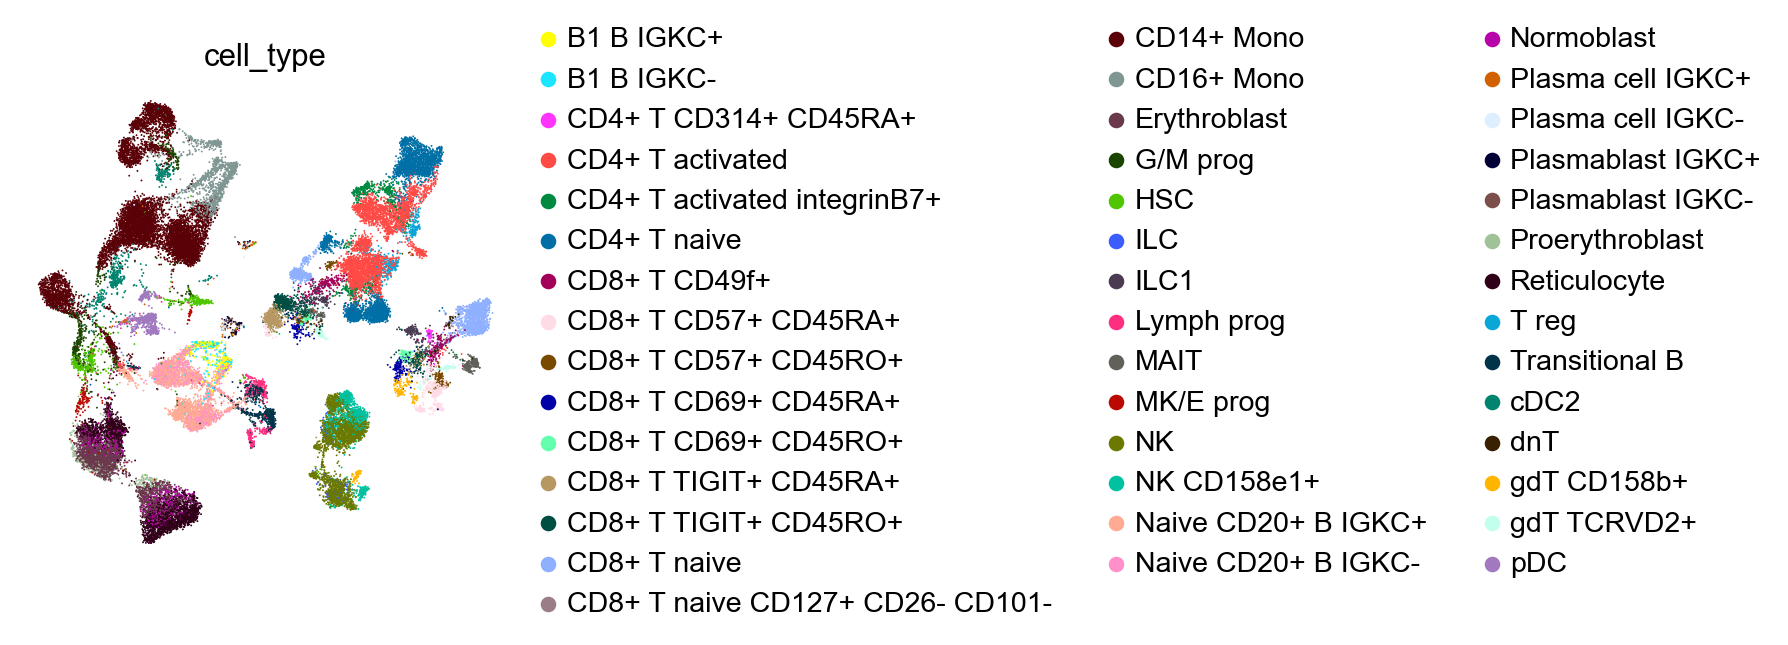

In [32]:
sc.pl.umap(adt_cite, color="cell_type", frameon=False)

## Graph construction

### Add RNA-ATAC edges, RNA nodes and ATAC nodes

In [33]:
scglue.data.get_gene_annotation(
    rna, gtf="gencode.v41.chr_patch_hapl_scaff.annotation.gtf",
    gtf_by="gene_name"
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
AL627309.5,NaN,NaN,NaN
LINC01409,chr1,778746.0,810065.0
LINC01128,chr1,825137.0,859446.0
NOC2L,chr1,944202.0,959309.0
KLHL17,chr1,960583.0,965719.0


In [34]:
rna = rna[:, ~rna.var["chrom"].isna()]
rna

View of AnnData object with n_obs × n_vars = 73951 × 11309
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'new_batch', 'GEX_n_genes_by_counts', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'ADT_pseudotime_order', 'is_train', 'concat_key'
    var: 'feature_types', 'gene_id-0', 'gene_id-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 

In [35]:
atac_multiom.var_names[:5]

Index(['chr1-9776-10668', 'chr1-180726-181005', 'chr1-181117-181803',
       'chr1-191133-192055', 'chr1-267562-268456'],
      dtype='object')

In [36]:
split = atac_multiom.var_names.str.split(r"[:-]")
atac_multiom.var["chrom"] = split.map(lambda x: x[0])
atac_multiom.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac_multiom.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
atac_multiom.var.head()

,feature_types,gene_id,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,chrom,chromStart,chromEnd
chr1-9776-10668,ATAC,NaN,False,0.031062,1.817257,0.674005,1,False,chr1,9776,10668
chr1-180726-181005,ATAC,NaN,True,0.026252,2.177327,1.565104,4,False,chr1,180726,181005
chr1-181117-181803,ATAC,NaN,False,0.052126,1.573240,0.250831,1,False,chr1,181117,181803
chr1-191133-192055,ATAC,NaN,True,0.017650,1.710112,0.624653,2,False,chr1,191133,192055
chr1-267562-268456,ATAC,NaN,False,0.012426,1.306993,-0.311734,0,False,chr1,267562,268456


In [37]:
guidance = scglue.genomics.rna_anchored_guidance_graph(rna, atac_multiom)
guidance

window_graph: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11309/11309 [00:01<00:00, 7676.79it/s]


In [38]:
scglue.graph.check_graph(guidance, [rna, atac_multiom])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [39]:
guidance.number_of_nodes(), guidance.number_of_edges()

(127799, 259729)

In [40]:
for _, e in zip(range(5), guidance.edges):
    print(f"{e}: {guidance.edges[e]}")

('LINC01409', 'chr1-778276-779191', 0): {'dist': 0, 'weight': 1.0, 'sign': 1, 'type': 'fwd'}
('LINC01409', 'LINC01409', 0): {'weight': 1.0, 'sign': 1, 'type': 'loop'}
('chr1-778276-779191', 'LINC01409', 0): {'dist': 0, 'weight': 1.0, 'sign': 1, 'type': 'rev'}
('chr1-778276-779191', 'chr1-778276-779191', 0): {'weight': 1.0, 'sign': 1, 'type': 'loop'}
('LINC01128', 'chr1-822804-823597', 0): {'dist': 0, 'weight': 1.0, 'sign': 1, 'type': 'fwd'}


### Add RNA-ADT edges and ADT nodes

In [41]:
adt_cite.var_names

Index(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E', 'CD82', 'CD101',
       'CD88', 'CD224'],
      dtype='object', length=134)

In [42]:
rna.var_names

Index(['LINC01409', 'LINC01128', 'NOC2L', 'KLHL17', 'ISG15', 'C1orf159',
       'SDF4', 'B3GALT6', 'UBE2J2', 'ACAP3',
       ...
       'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', length=11309)

In [43]:
len(set(rna.var_names).intersection(set(adt_cite.var_names)))

35

In [44]:
graph = guidance.copy()

In [45]:
p = np.array(adt_cite.var_names)
r = np.array(rna.var_names)
# mask entries are set to 1 where protein name is the same as gene name 
mask = np.repeat(p.reshape(-1, 1), r.shape[0], axis=1) == r
mask = np.array(mask)

In [46]:
prot_vars = [v + '_prot' for v in adt_cite.var_names]
adt_cite.var_names = prot_vars

In [47]:
rna_vars = rna.var_names

In [48]:
import pandas as pd
adj = pd.DataFrame(mask, index=prot_vars, columns=rna_vars)
diag_edges = adj[adj > 0].stack().index.tolist()
diag_edges_to_add = [(n1, n2, {'weight': 1., 'sign': 1}) for n1, n2 in diag_edges]
diag_edges_to_add.extend([(n2, n1, {'weight': 1., 'sign': 1}) for n1, n2 in diag_edges])
# self_loop_rna = [(g, g, {'weight': 1., 'sign': 1}) for g in rna_vars]
self_loop_prot = [(g, g, {'weight': 1., 'sign': 1}) for g in prot_vars]

In [49]:
graph.add_nodes_from(prot_vars)
graph.add_edges_from(diag_edges_to_add)
graph.add_edges_from(self_loop_prot)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [50]:
graph.number_of_nodes(), graph.number_of_edges()

(127933, 259933)

In [51]:
#unpaired configurations
scglue.models.configure_dataset(
    rna, 
    "NB", 
    use_highly_variable=True,
    use_layer="counts", 
    use_rep="X_pca",
    use_batch="Samplename",#batch 
)

/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/scglue/models/__init__.py:124: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[config.ANNDATA_KEY] = data_config


In [52]:
#unpaired configurations
scglue.models.configure_dataset(
    atac_multiom, 
    "NB", 
    use_highly_variable=True,
    use_layer="counts", 
    use_rep="X_lsi",
    use_batch="Samplename", #batch
)

In [53]:
#unpaired configurations
scglue.models.configure_dataset(
    adt_cite, 
    "Normal", 
    use_highly_variable=False,
    use_rep="X_pca",
    use_batch="Samplename",#batch
)

In [54]:
scglue.graph.check_graph(graph, [rna, atac_multiom, adt_cite])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [56]:
#subgraph highly variable
from itertools import chain

graph_hvf = graph.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac_multiom.var.query("highly_variable").index,
    adt_cite.var.index
)).copy()

In [59]:
#glue_trimodal = scglue.models.fit_SCGLUE(
    #{"rna": rna, "atac": atac_multiom, "adt": adt_cite},
    #graph, #without highly var subgraph
    #fit_kws={"directory": "glue"}
#)

In [58]:
glue_trimodal = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac_multiom, "adt": adt_cite},
    graph_hvf, #with highly var subgraph
    fit_kws={"directory": "glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 29695
[INFO] SCGLUEModel: Setting `max_epochs` = 48
[INFO] SCGLUEModel: Setting `patience` = 4
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 2
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.43, 'g_kl': 0.006, 'g_elbo': 0.435, 'x_rna_nll': 0.317, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.323, 'x_atac_nll': 0.138, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.138, 'x_adt_nll': 0.245, 'x_adt_kl': 0.114, 'x_adt_elbo': 0.359, 'dsc_loss': 1.064, 'vae_loss': 0.847, 'gen_loss': 0.793}, val={'g_nll': 0.429, 'g_kl': 0.006, 'g_elbo': 0.435, 'x_rna_nll': 0.317, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.323, 'x_atac_nll': 0.139, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.14, '

2023-07-24 22:43:55,028 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "21"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...


/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[INFO] estimate_balancing_weight: Matching array shape = (27, 27, 22)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 29695
[INFO] SCGLUEModel: Setting `align_burnin` = 8
[INFO] SCGLUEModel: Setting `max_epochs` = 48
[INFO] SCGLUEModel: Setting `patience` = 4
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 2
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.424, 'g_kl': 0.005, 'g_elbo': 0.429, 'x_rna_nll': 0.321, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.326, 'x_atac_nll': 0.137, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.138, 'x_adt_nll': 0.242, 'x_adt_kl': 0.114, 'x_adt_elbo': 0.355, 'dsc_loss': 1.046, 'vae_loss': 0.845, 'gen_loss

2023-07-25 16:34:23,265 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "26"...


In [60]:
rna.obsm["X_glue"] = glue_trimodal.encode_data("rna", rna)
atac_multiom.obsm["X_glue"] = glue_trimodal.encode_data("atac", atac_multiom)
adt_cite.obsm["X_glue"] = glue_trimodal.encode_data("adt", adt_cite)

In [61]:
rna.obs['assay'] = 'rna'
atac_multiom.obs['assay'] = 'atac'
adt_cite.obs['assay'] = 'adt'

In [62]:
combined = ad.concat([rna, atac_multiom, adt_cite])

/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [63]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)

In [64]:
combined

AnnData object with n_obs × n_vars = 147902 × 0
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'new_batch', 'balancing_weight', 'assay'
    uns: 'neighbors', 'umap'
    obsm: 'GEX_X_pca', 'GEX_X_umap', 'X_umap', 'X_glue'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/maiia.shulman/anaconda3/envs/glue/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


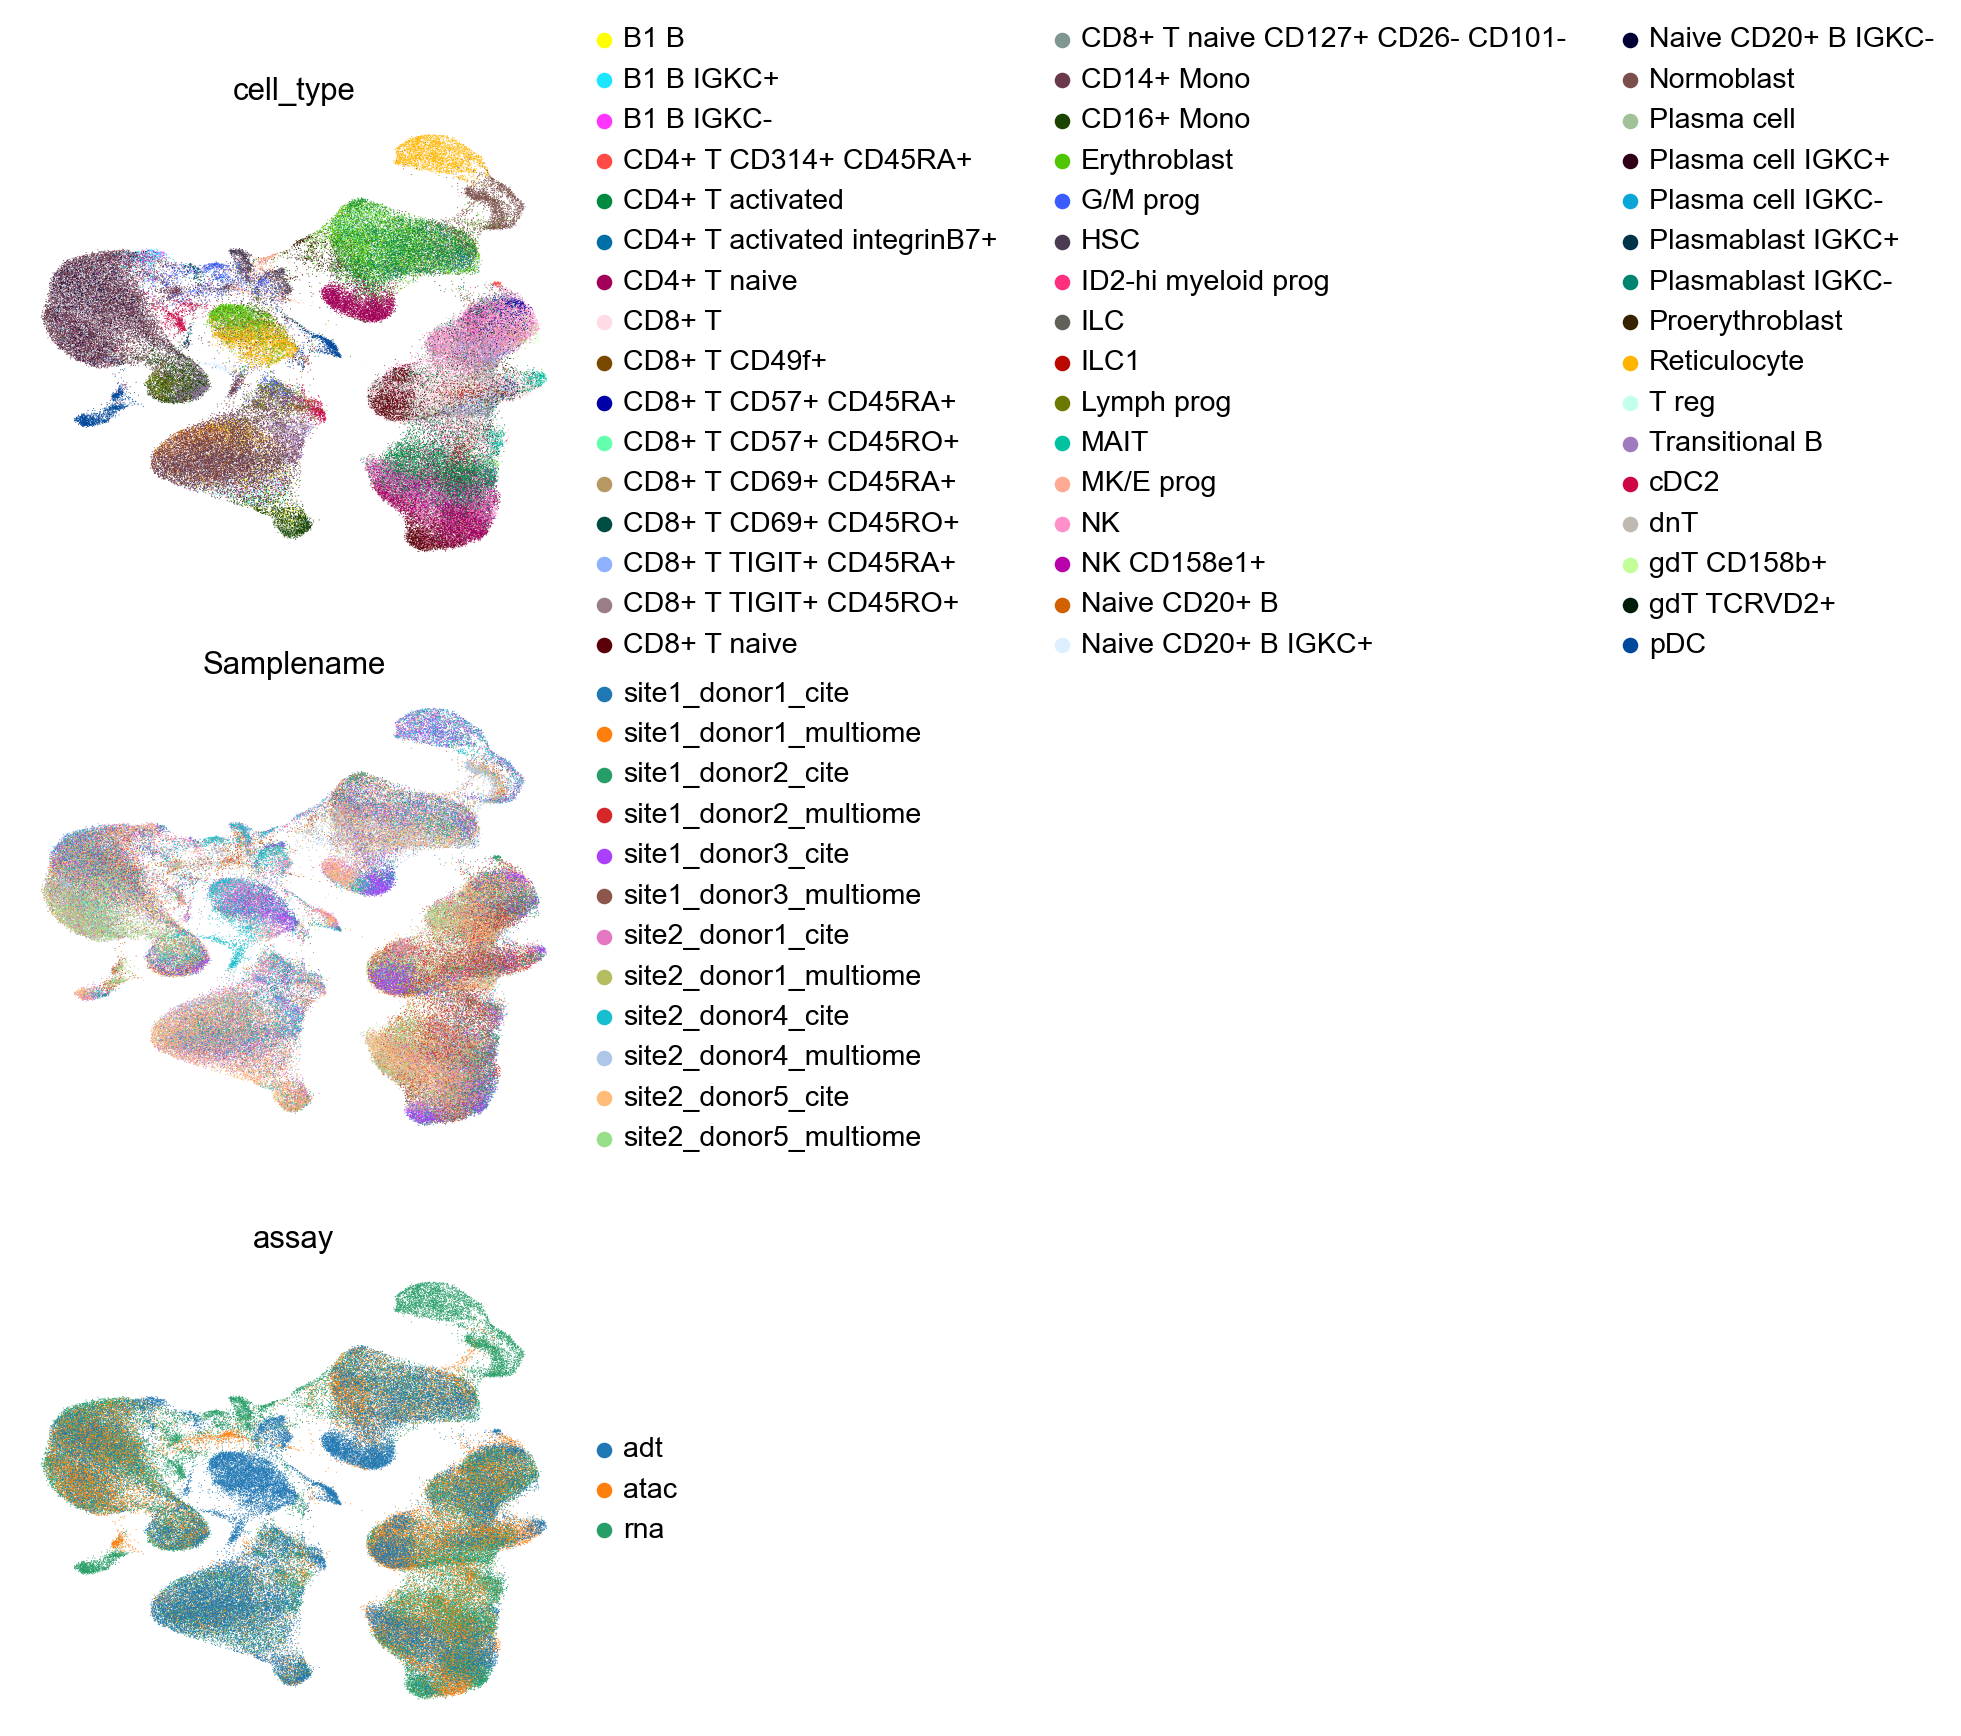

In [65]:
sc.pl.umap(combined, color=["cell_type", "Samplename", "assay"], ncols=1, frameon=False)

In [66]:
#save AnnData object
combined.write('glue_trimodal_unpaired_integrated_highly_var.h5ad')